# Inventory Control

Step 1: EOQ: Economic Order Quantity

- EOQ tells us the optimal lot size to order that minimizes costs.


Step 2: ROP: Reorder Point

- ROP tells us when to reorder before stockouts happen.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
forecast_df = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\forecast.csv', parse_dates=['date'], dayfirst=True)

In [4]:
forecast_df.head()

,id,date,store,item,sales
0,0,01-01-2018,1,1,12.199787
1,1,02-01-2018,1,1,12.050390
2,2,03-01-2018,1,1,12.402985
3,3,04-01-2018,1,1,13.604758
4,4,05-01-2018,1,1,14.364701


Select a specific Store + Item SKU (so we optimize per SKU).

In [65]:
# Select SKU
store_id, item_id = 1, 1
subset = forecast_df[(forecast_df['store']==store_id) & (forecast_df['item']==item_id)].copy()
subset = subset.sort_values('date').reset_index(drop=True)

avg_daily_demand: average sales per day (used for EOQ & ROP).

std_daily_demand: standard deviation of daily demand (used for safety stock).

annual_demand: scales demand up to 1 year for EOQ calculations.

In [66]:
# Demand stats
avg_daily_demand = subset['sales'].mean()
std_daily_demand = subset['sales'].std(ddof=1)
annual_demand = avg_daily_demand * 365

S = ordering cost (fixed cost every time you order).

H = holding cost (per unit per year → discourages very large orders).

Lead time = how many days until replenishment arrives.

z = controls service level: higher z means less stockouts but more inventory.

In [ ]:
# Inventory economics (tuned)
ordering_cost = 20     # S
holding_cost = 50      # H (per unit per year)
lead_time = 7          # days
z = 1.65               # service level for safety stock


EOQ (Economic Order Quantity): optimal order size minimizing cost tradeoff.

Safety stock: extra buffer depending on demand volatility.

ROP (Reorder Point): when inventory hits this, place an order.

In [90]:
# EOQ & ROP (data-driven)
EOQ = np.sqrt((2 * annual_demand * ordering_cost) / holding_cost)
safety_stock = z * std_daily_demand * np.sqrt(lead_time)
ROP = avg_daily_demand * lead_time + safety_stock

"""
Limits EOQ to not exceed 90 days’ demand.

Starts inventory at a stable level (near ROP + half EOQ).
"""

# Cap EOQ so it doesn't become unrealistically huge (optional)
max_days_to_order = 90  # at most 90 days of demand
EOQ = min(EOQ, avg_daily_demand * max_days_to_order)

# Initial stock near steady state
initial_stock = int(ROP + EOQ/2)

print(f"Avg daily demand: {avg_daily_demand:.2f}")
print(f"Std daily demand: {std_daily_demand:.2f}")
print(f"EOQ: {EOQ:.0f}, ROP: {ROP:.0f}, initial stock: {initial_stock}")

initial_stock = int(2*ROP + EOQ/2)

Avg daily demand: 20.68
Std daily demand: 6.73
EOQ: 78, ROP: 174, initial stock: 212


Simulation Loop:

Runs day by day.

Deducts sales from stock.

If stock dips below ROP, places one order (arrives after lead time).

Tracks:

- inventory_levels (daily stock levels),

- reorder_flags (1 if reordered that day),

- orders_placed (history of orders).

In [81]:
# --- Simulation with lead time & single outstanding order ---
inventory_levels = []
reorder_flags = []
orders_placed = []   # (index, date, qty, arrival_index)

stock = initial_stock
order_outstanding = False  # True while an outstanding order is on the way
arrival_index = None

for i, row in subset.iterrows():
    # Receive order(s) if they arrive today
    if order_outstanding and arrival_index == i:
        stock += EOQ
        order_outstanding = False
        arrival_index = None

    # Demand consumes inventory
    stock -= row['sales']

    # Place order only if stock <= ROP AND there is no outstanding order
    if (stock <= ROP) and (not order_outstanding):
        # place one order that will arrive after lead_time days
        arrival_idx = i + lead_time
        # If arrival index beyond horizon, we still schedule it but it won't arrive in plotted horizon
        orders_placed.append((i, row['date'], int(EOQ), arrival_idx))
        order_outstanding = True
        arrival_index = arrival_idx
        reorder_flags.append(1)
    else:
        reorder_flags.append(0)

    inventory_levels.append(stock)

In [93]:
# Attach results
subset['inventory_level'] = inventory_levels
subset['reorder'] = reorder_flags

C:\Users\kvjai\AppData\Local\Temp\ipykernel_17376\2120391857.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\kvjai\AppData\Local\Temp\ipykernel_17376\2120391857.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



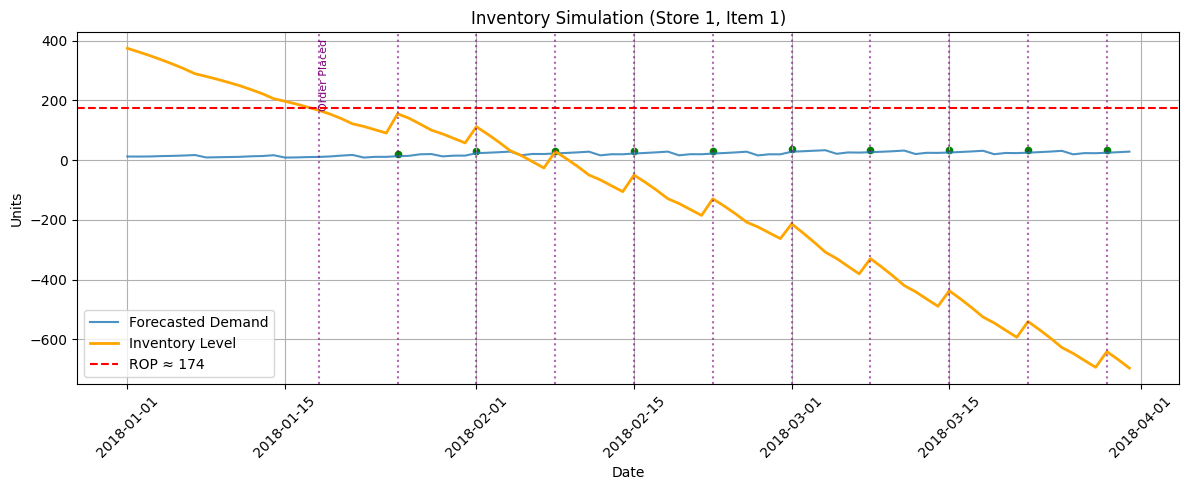

In [94]:
# --- Plot (limit window for clarity) ---
# choose a plotting window (e.g., first 120 days or full length if short)
plot_window = subset  # or subset.iloc[:120]
plt.figure(figsize=(12,5))
plt.plot(plot_window['date'], plot_window['sales'], label='Forecasted Demand', alpha=0.8)
plt.plot(plot_window['date'], plot_window['inventory_level'], label='Inventory Level', color='orange', linewidth=2)
plt.axhline(ROP, color='red', linestyle='--', label=f'ROP ≈ {ROP:.0f}')


# mark order placements (vertical lines at order date) and arrival (optional)
first_label = True
for (idx, ord_date, qty, arr_idx) in orders_placed:
    plt.axvline(ord_date, color='purple', linestyle=':', alpha=0.6)
    # annotate once
    if first_label:
        plt.text(ord_date, plt.ylim()[1]*0.95, 'Order Placed', rotation=90, va='top', fontsize=8, color='purple')
        first_label = False
    # also mark arrival if within window
    if arr_idx < len(subset):
        plt.scatter(subset.loc[arr_idx, 'date'], subset.loc[arr_idx, 'sales']+ROP*0.05, color='green', s=20)

plt.title(f'Inventory Simulation (Store {store_id}, Item {item_id})')
plt.xlabel('Date')
plt.ylabel('Units')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
# --- Summary metrics ---
total_orders = len(orders_placed)
avg_inventory = np.mean(subset['inventory_level'])
print(f"Total orders placed in horizon: {total_orders}")
print(f"Average inventory level: {avg_inventory:.1f}")

"""
Tells you how many orders were placed in the horizon.

Computes average inventory (helps calculate holding costs & efficiency).
"""

Total orders placed in horizon: 11
Average inventory level: -122.2


'\nTells you how many orders were placed in the horizon.\n\nComputes average inventory (helps calculate holding costs & efficiency).\n'

In [96]:
print(subset.head())

#A reorder column marking reorder days (1 = order placed).

   id       date  store  item      sales   inventory  inventory_level  reorder
0   0 2018-01-01      1     1  12.199787  290.049605       374.800213        0
1   1 2018-01-02      1     1  12.050390  380.248607       362.749823        0
2   2 2018-01-03      1     1  12.402985  367.845622       350.346838        0
3   3 2018-01-04      1     1  13.604758  354.240864       336.742080        0
4   4 2018-01-05      1     1  14.364701  339.876163       322.377379        0


In [97]:
import plotly.express as px

forecast_df['date'] = pd.to_datetime(forecast_df['date'], dayfirst=True)

# Example: single store & item
subset = forecast_df[(forecast_df['store'] == 1) & (forecast_df['item'] == 1)]

fig = px.line(subset, x="date", y="sales", title="Forecasted Sales (Store 1 - Item 1)")
fig.show()
